# Sentiment Analysis with spaCy and Advanced Models

## Introduction

This notebook demonstrates an improved approach to sentiment analysis using natural language processing (NLP) with the spaCy library and more advanced machine learning models. The goal is to accurately classify text as expressing positive or negative sentiment.


In [1]:
import os

In [2]:
!pip install torch transformers

In [3]:
import spacy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

In [4]:
df_train = pd.read_csv("emotions_train_data.txt", sep=";", names=["text", "emotion"])
df_test = pd.read_csv("emotions_test_data.txt", sep=";", names=["text", "emotion"])

In [5]:
# Preprocess text with spaCy
nlp = spacy.load("en_core_web_lg")

In [6]:
df_train.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [7]:
def preprocess(text):
    doc = nlp(text)
    
    tokens = [] 
    for token in doc:
        if not token.is_punct and not token.is_space and not token.like_num:
            tokens.append(token.lemma_.lower())

    return " ".join(tokens)

In [8]:
df_train['preprocessed_text'] = df_train['text'].apply(preprocess) 

In [9]:
# Split train data into train and validation
X_train, X_val, y_train, y_val = train_test_split(df_train['preprocessed_text'], df_train['emotion'], test_size=0.2, random_state=42)

In [10]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train) 
X_val_vect = vectorizer.transform(X_val)

In [11]:
# Train and evaluate models
def evaluate_model(model):
    model.fit(X_train_vect, y_train)
    preds = model.predict(X_val_vect)
    print(f"{type(model).__name__} Accuracy: {accuracy_score(y_val, preds):.3f}")
    print(classification_report(y_val, preds))

models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(),
    LinearSVC()
]

for model in models:
    evaluate_model(model)

LogisticRegression Accuracy: 0.537
              precision    recall  f1-score   support

       anger       0.78      0.27      0.41        51
        fear       0.73      0.17      0.28        46
         joy       0.48      0.91      0.63       127
        love       1.00      0.02      0.04        46
     sadness       0.60      0.64      0.62       118
    surprise       0.00      0.00      0.00        12

    accuracy                           0.54       400
   macro avg       0.60      0.34      0.33       400
weighted avg       0.63      0.54      0.47       400



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

RandomForestClassifier Accuracy: 0.545
              precision    recall  f1-score   support

       anger       0.84      0.31      0.46        51
        fear       0.75      0.33      0.45        46
         joy       0.45      0.91      0.60       127
        love       0.94      0.35      0.51        46
     sadness       0.62      0.43      0.51       118
    surprise       1.00      0.42      0.59        12

    accuracy                           0.55       400
   macro avg       0.77      0.46      0.52       400
weighted avg       0.66      0.55      0.53       400

LinearSVC Accuracy: 0.720
              precision    recall  f1-score   support

       anger       0.80      0.73      0.76        51
        fear       0.77      0.59      0.67        46
         joy       0.65      0.86      0.74       127
        love       0.88      0.46      0.60        46
     sadness       0.74      0.73      0.73       118
    surprise       0.73      0.67      0.70        12

    accuracy

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


# Deep Learning with BERT

In [12]:
# df with train and test sets
df = pd.concat([df_train, df_test])

In [13]:
df['emotion'].unique()

array(['sadness', 'love', 'anger', 'joy', 'fear', 'surprise'],
      dtype=object)

In [14]:
# Load BERT model and tokenizer 
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def emotion_encoder(df):
    df.replace("surprise", 1, inplace=True)
    df.replace("love", 1, inplace=True)
    df.replace("joy", 1, inplace=True)
    df.replace("fear", 0, inplace=True)
    df.replace("anger", 0, inplace=True)
    df.replace("sadness", 0, inplace=True)

In [16]:
X = df['text']
y = df['emotion']
emotion_encoder(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/3q/r2zc74911hn2f967w656zszm0000gn/T/ipykernel_36779/2398407963.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("sadness", 0, inplace=True)


In [17]:
X_train.head()

1994                             i can feel its suffering
423     i enjoyed it for the most part for an entertai...
991     ive had a few rough days since then and in the...
1221    i can say is that despite my occasional jokes ...
506     i dont come from a perfect past i come from a ...
Name: text, dtype: object

In [18]:
def tokenize(text):
    return tokenizer(text, padding=True, truncation=True, return_tensors='pt')

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments

In [20]:
train_encodings = tokenize(X_train.tolist())
train_labels = torch.tensor(y_train.tolist())
train_dataset = TensorDataset(train_encodings['input_ids'].squeeze(), 
                              train_encodings['attention_mask'].squeeze(), 
                              train_labels)

In [21]:
test_encodings = tokenize(X_test.tolist())
test_labels = torch.tensor(y_test.tolist())
test_dataset = TensorDataset(test_encodings['input_ids'].squeeze(), 
                             test_encodings['attention_mask'].squeeze(), 
                             test_labels)

In [22]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

In [23]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=lambda data: {
        'input_ids': torch.stack([f[0] for f in data]),
        'attention_mask': torch.stack([f[1] for f in data]),
        'labels': torch.stack([f[2] for f in data])
    },
    compute_metrics=compute_metrics
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
import matplotlib.pyplot as plt

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: anri-m-lombard (anri-lombard). Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Di

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/600 [00:00<?, ?it/s]

{'loss': 0.731, 'grad_norm': 3.3513808250427246, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.05}
{'loss': 0.7192, 'grad_norm': 2.8848929405212402, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.1}
{'loss': 0.7248, 'grad_norm': 6.732677459716797, 'learning_rate': 3e-06, 'epoch': 0.15}
{'loss': 0.6896, 'grad_norm': 2.828784227371216, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.2}
{'loss': 0.7019, 'grad_norm': 5.559428691864014, 'learning_rate': 5e-06, 'epoch': 0.25}
{'loss': 0.6812, 'grad_norm': 3.8696274757385254, 'learning_rate': 6e-06, 'epoch': 0.3}
{'loss': 0.633, 'grad_norm': 5.832087516784668, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.35}
{'loss': 0.6432, 'grad_norm': 7.036718845367432, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.4}
{'loss': 0.6231, 'grad_norm': 5.321320533752441, 'learning_rate': 9e-06, 'epoch': 0.45}
{'loss': 0.5429, 'grad_norm': 7.415954113006592, 'learning_rate': 1e-05, 'epoch': 0.5}
{'loss': 0.5041, 'grad_norm': 8.7378005981

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.2688598036766052, 'eval_accuracy': 0.9075, 'eval_runtime': 5.5788, 'eval_samples_per_second': 143.399, 'eval_steps_per_second': 2.33, 'epoch': 1.0}
{'loss': 0.2017, 'grad_norm': 1.3138208389282227, 'learning_rate': 2.1e-05, 'epoch': 1.05}
{'loss': 0.2197, 'grad_norm': 3.330958604812622, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.1}
{'loss': 0.2392, 'grad_norm': 11.154090881347656, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.15}
{'loss': 0.2478, 'grad_norm': 12.46111011505127, 'learning_rate': 2.4e-05, 'epoch': 1.2}
{'loss': 0.1312, 'grad_norm': 17.72269058227539, 'learning_rate': 2.5e-05, 'epoch': 1.25}
{'loss': 0.2277, 'grad_norm': 3.106731653213501, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.3}
{'loss': 0.2507, 'grad_norm': 7.689471244812012, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.35}
{'loss': 0.3427, 'grad_norm': 14.654104232788086, 'learning_rate': 2.8000000000000003e-05, 'epoch': 1.4}
{'loss': 0.1636, 'grad_norm': 5.6312985420

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.18657371401786804, 'eval_accuracy': 0.95625, 'eval_runtime': 4.6248, 'eval_samples_per_second': 172.982, 'eval_steps_per_second': 2.811, 'epoch': 2.0}
{'loss': 0.0955, 'grad_norm': 0.10543881356716156, 'learning_rate': 4.1e-05, 'epoch': 2.05}
{'loss': 0.0676, 'grad_norm': 8.251967430114746, 'learning_rate': 4.2e-05, 'epoch': 2.1}
{'loss': 0.0317, 'grad_norm': 10.577871322631836, 'learning_rate': 4.3e-05, 'epoch': 2.15}
{'loss': 0.0612, 'grad_norm': 0.10848495364189148, 'learning_rate': 4.4000000000000006e-05, 'epoch': 2.2}
{'loss': 0.147, 'grad_norm': 9.305208206176758, 'learning_rate': 4.5e-05, 'epoch': 2.25}
{'loss': 0.1703, 'grad_norm': 0.5520910620689392, 'learning_rate': 4.600000000000001e-05, 'epoch': 2.3}
{'loss': 0.0409, 'grad_norm': 6.052298545837402, 'learning_rate': 4.7e-05, 'epoch': 2.35}
{'loss': 0.1795, 'grad_norm': 3.776885986328125, 'learning_rate': 4.8e-05, 'epoch': 2.4}
{'loss': 0.1196, 'grad_norm': 9.537435531616211, 'learning_rate': 4.9e-05, 'epoch':

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.1951349377632141, 'eval_accuracy': 0.95375, 'eval_runtime': 5.2285, 'eval_samples_per_second': 153.008, 'eval_steps_per_second': 2.486, 'epoch': 3.0}
{'train_runtime': 352.3499, 'train_samples_per_second': 27.246, 'train_steps_per_second': 1.703, 'train_loss': 0.27231992048521836, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

{'loss': 0.0406, 'grad_norm': 18.215635299682617, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.05}
{'loss': 0.1416, 'grad_norm': 0.21140030026435852, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.1}
{'loss': 0.0974, 'grad_norm': 25.5891056060791, 'learning_rate': 3e-06, 'epoch': 0.15}
{'loss': 0.0647, 'grad_norm': 0.19597691297531128, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.2}
{'loss': 0.1207, 'grad_norm': 0.14698703587055206, 'learning_rate': 5e-06, 'epoch': 0.25}
{'loss': 0.0475, 'grad_norm': 0.17880704998970032, 'learning_rate': 6e-06, 'epoch': 0.3}
{'loss': 0.055, 'grad_norm': 0.15962101519107819, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.35}
{'loss': 0.0793, 'grad_norm': 0.12684372067451477, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.4}
{'loss': 0.0059, 'grad_norm': 0.1164880320429802, 'learning_rate': 9e-06, 'epoch': 0.45}
{'loss': 0.0752, 'grad_norm': 0.1275833696126938, 'learning_rate': 1e-05, 'epoch': 0.5}
{'loss': 0.0561, 'grad_norm': 

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.15506821870803833, 'eval_accuracy': 0.9675, 'eval_runtime': 4.1422, 'eval_samples_per_second': 193.134, 'eval_steps_per_second': 3.138, 'epoch': 1.0}
{'loss': 0.0252, 'grad_norm': 0.04300520569086075, 'learning_rate': 2.1e-05, 'epoch': 1.05}
{'loss': 0.1119, 'grad_norm': 0.04195025563240051, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.1}
{'loss': 0.0902, 'grad_norm': 6.568905353546143, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.15}
{'loss': 0.058, 'grad_norm': 0.1034184992313385, 'learning_rate': 2.4e-05, 'epoch': 1.2}
{'loss': 0.0371, 'grad_norm': 0.056751590222120285, 'learning_rate': 2.5e-05, 'epoch': 1.25}
{'loss': 0.0115, 'grad_norm': 20.59679412841797, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.3}
{'loss': 0.0582, 'grad_norm': 0.06103917583823204, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.35}
{'loss': 0.0433, 'grad_norm': 0.10225656628608704, 'learning_rate': 2.8000000000000003e-05, 'epoch': 1.4}
{'loss': 0.0327, 'grad_norm': 0.

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.21122844517230988, 'eval_accuracy': 0.95875, 'eval_runtime': 3.9602, 'eval_samples_per_second': 202.008, 'eval_steps_per_second': 3.283, 'epoch': 2.0}
{'loss': 0.0302, 'grad_norm': 0.016012322157621384, 'learning_rate': 4.1e-05, 'epoch': 2.05}
{'loss': 0.0195, 'grad_norm': 0.06622493267059326, 'learning_rate': 4.2e-05, 'epoch': 2.1}
{'loss': 0.0025, 'grad_norm': 0.009627931751310825, 'learning_rate': 4.3e-05, 'epoch': 2.15}
{'loss': 0.0005, 'grad_norm': 0.009290593676269054, 'learning_rate': 4.4000000000000006e-05, 'epoch': 2.2}
{'loss': 0.0818, 'grad_norm': 70.55670928955078, 'learning_rate': 4.5e-05, 'epoch': 2.25}
{'loss': 0.0008, 'grad_norm': 0.2854941487312317, 'learning_rate': 4.600000000000001e-05, 'epoch': 2.3}
{'loss': 0.0759, 'grad_norm': 12.112178802490234, 'learning_rate': 4.7e-05, 'epoch': 2.35}
{'loss': 0.1494, 'grad_norm': 60.551822662353516, 'learning_rate': 4.8e-05, 'epoch': 2.4}
{'loss': 0.1257, 'grad_norm': 0.8987879753112793, 'learning_rate': 4.9e-05

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.23258405923843384, 'eval_accuracy': 0.95875, 'eval_runtime': 4.9847, 'eval_samples_per_second': 160.49, 'eval_steps_per_second': 2.608, 'epoch': 3.0}
{'train_runtime': 337.8673, 'train_samples_per_second': 28.414, 'train_steps_per_second': 1.776, 'train_loss': 0.053031935065519065, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

{'loss': 0.0261, 'grad_norm': 0.5705716609954834, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.05}
{'loss': 0.114, 'grad_norm': 0.04606282711029053, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.1}
{'loss': 0.0678, 'grad_norm': 0.07016687840223312, 'learning_rate': 3e-06, 'epoch': 0.15}
{'loss': 0.0695, 'grad_norm': 0.05290444940328598, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.2}
{'loss': 0.1129, 'grad_norm': 0.07199165225028992, 'learning_rate': 5e-06, 'epoch': 0.25}
{'loss': 0.0378, 'grad_norm': 0.0651053637266159, 'learning_rate': 6e-06, 'epoch': 0.3}
{'loss': 0.0062, 'grad_norm': 0.05535995215177536, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.35}
{'loss': 0.0386, 'grad_norm': 0.04567122831940651, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.4}
{'loss': 0.0017, 'grad_norm': 0.044744089245796204, 'learning_rate': 9e-06, 'epoch': 0.45}
{'loss': 0.0384, 'grad_norm': 0.038107436150312424, 'learning_rate': 1e-05, 'epoch': 0.5}
{'loss': 0.0314, 'grad_n

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.19511783123016357, 'eval_accuracy': 0.96375, 'eval_runtime': 4.0345, 'eval_samples_per_second': 198.289, 'eval_steps_per_second': 3.222, 'epoch': 1.0}
{'loss': 0.0239, 'grad_norm': 0.013744358904659748, 'learning_rate': 2.1e-05, 'epoch': 1.05}
{'loss': 0.1156, 'grad_norm': 0.02423221617937088, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.1}
{'loss': 0.0468, 'grad_norm': 0.1405574381351471, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.15}
{'loss': 0.0713, 'grad_norm': 0.08049789816141129, 'learning_rate': 2.4e-05, 'epoch': 1.2}
{'loss': 0.0017, 'grad_norm': 0.05213026702404022, 'learning_rate': 2.5e-05, 'epoch': 1.25}
{'loss': 0.0013, 'grad_norm': 0.16613246500492096, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.3}
{'loss': 0.021, 'grad_norm': 0.02022903598845005, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.35}
{'loss': 0.1389, 'grad_norm': 0.016675075516104698, 'learning_rate': 2.8000000000000003e-05, 'epoch': 1.4}
{'loss': 0.035, 'grad_norm

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.16908065974712372, 'eval_accuracy': 0.9725, 'eval_runtime': 3.896, 'eval_samples_per_second': 205.341, 'eval_steps_per_second': 3.337, 'epoch': 2.0}
{'loss': 0.0704, 'grad_norm': 0.22107604146003723, 'learning_rate': 4.1e-05, 'epoch': 2.05}
{'loss': 0.0349, 'grad_norm': 0.15659089386463165, 'learning_rate': 4.2e-05, 'epoch': 2.1}
{'loss': 0.109, 'grad_norm': 0.010776970535516739, 'learning_rate': 4.3e-05, 'epoch': 2.15}
{'loss': 0.0469, 'grad_norm': 0.03708041086792946, 'learning_rate': 4.4000000000000006e-05, 'epoch': 2.2}
{'loss': 0.1171, 'grad_norm': 0.07480865716934204, 'learning_rate': 4.5e-05, 'epoch': 2.25}
{'loss': 0.0296, 'grad_norm': 3.914290189743042, 'learning_rate': 4.600000000000001e-05, 'epoch': 2.3}
{'loss': 0.0398, 'grad_norm': 21.87028694152832, 'learning_rate': 4.7e-05, 'epoch': 2.35}
{'loss': 0.0966, 'grad_norm': 15.432045936584473, 'learning_rate': 4.8e-05, 'epoch': 2.4}
{'loss': 0.0205, 'grad_norm': 0.01949693076312542, 'learning_rate': 4.9e-05, 'e

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.21784228086471558, 'eval_accuracy': 0.95375, 'eval_runtime': 3.2295, 'eval_samples_per_second': 247.715, 'eval_steps_per_second': 4.025, 'epoch': 3.0}
{'train_runtime': 298.5789, 'train_samples_per_second': 32.152, 'train_steps_per_second': 2.01, 'train_loss': 0.05030278525625666, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

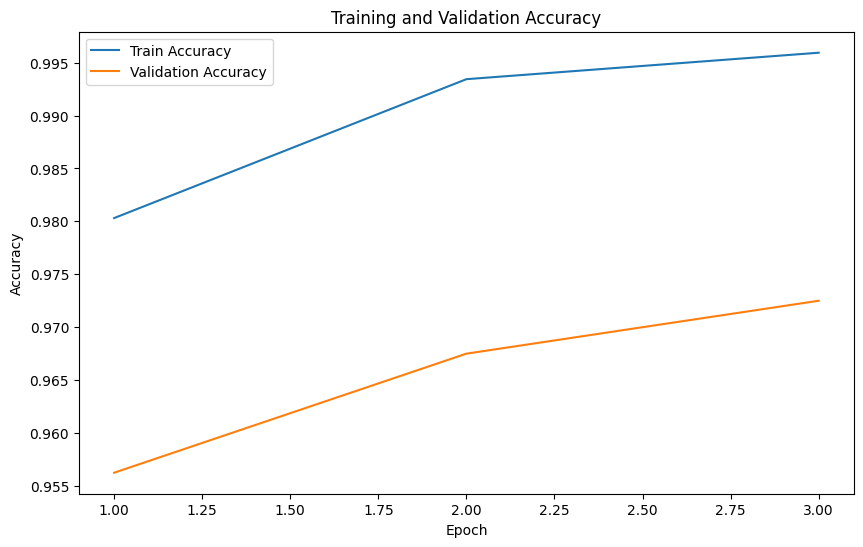

In [26]:
# Create lists to store evaluation metrics
train_accuracies = []
eval_accuracies = []

# Training and evaluation loop
for epoch in range(training_args.num_train_epochs):
    # Training
    trainer.train()
    
    # Evaluation on training set
    train_metrics = trainer.evaluate(train_dataset)
    train_accuracies.append(train_metrics['eval_accuracy'])
    
    # Evaluation on validation set
    eval_metrics = trainer.evaluate(test_dataset)
    eval_accuracies.append(eval_metrics['eval_accuracy'])

# Plot the evaluation metrics
epochs = range(1, training_args.num_train_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, eval_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [27]:
# Skip plotting and just train the model
# trainer.train()

In [28]:
# Evaluate on the test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
test_accuracy = accuracy_score(test_labels, preds)
print(f"Test Accuracy: {test_accuracy:.3f}")

  0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy: 0.973


In [32]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [34]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [37]:
examples = [
    # Positive examples
    "The movie was an absolute masterpiece! The storytelling was captivating, the cinematography was breathtaking, and the performances were outstanding. It left me in awe and deeply moved.",
    "I am thrilled with my new smartphone! It has exceeded all my expectations with its lightning-fast performance, stunning display, and innovative features. It has truly revolutionized my daily life.",
    
    # Negative examples
    "The customer service I received was appalling. The representative was rude, dismissive, and utterly unhelpful. I felt frustrated and disrespected throughout the entire interaction.",
    "I had high hopes for this novel, but it turned out to be a massive disappointment. The plot was convoluted, the characters were one-dimensional, and the writing style was tedious. I struggled to finish it.",
    
    # Neutral examples
    "The weather today is quite typical for this time of year. It's not too hot or too cold, with a mix of sunshine and clouds. It's a fairly average day overall.",
    "I recently tried a new restaurant in town. The food was decent, but nothing extraordinary. The service was adequate, and the ambiance was pleasant enough. It was an average dining experience.",
    
    # Hard to classify examples
    "The movie had its moments of brilliance, but it also had its flaws. The acting was top-notch, but the pacing felt uneven at times. It's a film that left me with mixed feelings.",
    "I have been using this software for a while now, and it has both strengths and weaknesses. It excels at certain tasks but falls short in others. My opinion is divided on its overall effectiveness.",
    "The book delved into complex themes and raised thought-provoking questions, but the writing style wasn't always engaging. It challenged my perceptions but didn't fully resonate with me emotionally.",
    "The concert had an incredible lineup of artists, but the venue's sound system was subpar. The performances were energetic, but the crowd's behavior was sometimes disruptive. It was a mix of highs and lows.",
]

def preprocess_input(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    return tokens['input_ids'], tokens['attention_mask']

for example in examples:
    input_ids, attention_mask = preprocess_input(example)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    if predicted_class == 1:
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'

    print(f"Example: {example}")
    print(f"Predicted sentiment: {sentiment}")
    print()

Example: The movie was an absolute masterpiece! The storytelling was captivating, the cinematography was breathtaking, and the performances were outstanding. It left me in awe and deeply moved.
Predicted sentiment: Positive

Example: I am thrilled with my new smartphone! It has exceeded all my expectations with its lightning-fast performance, stunning display, and innovative features. It has truly revolutionized my daily life.
Predicted sentiment: Positive

Example: The customer service I received was appalling. The representative was rude, dismissive, and utterly unhelpful. I felt frustrated and disrespected throughout the entire interaction.
Predicted sentiment: Negative

Example: I had high hopes for this novel, but it turned out to be a massive disappointment. The plot was convoluted, the characters were one-dimensional, and the writing style was tedious. I struggled to finish it.
Predicted sentiment: Negative

Example: The weather today is quite typical for this time of year. It's

In [29]:
# TODO: make a chatbot

# Scenario 1: don't use api
# 1. Import chat model from huggingface (llama chat variant)
# 2. Prompt engineering (tell this model given this input, this is my output) or use default
# 3. Decide to fine-tune on specific conversations data (company you work for) ******
# 3.1. Fine-tune --> expensive and takes a bit of time
# 3.2. Use Retrieval Augmented Generation (RAG) --> faster and cheaper with similar performance
# 3.3. Use Agents with RAG --> many different agents do different tasks depending on what is asked
# 4. Start chatting :)

# Great resource to learn all this: Deeplearning.AI (and we'll touch on it in revision weeks)